## Импорт бибилиотек и функции

In [1]:
# импорт нужных бибилиотек
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from keras.utils import to_categorical

from skimage import exposure

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import Xception

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split

## Загрузка набора данных

In [2]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Dec 21 12:03 kaggle.json


In [4]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d emmarex/plantdisease

100% 657M/658M [00:05<00:00, 94.0MB/s]
100% 658M/658M [00:05<00:00, 117MB/s] 


# Чтение данных

In [ ]:
# разархивирование данных
!unzip "/content/plantdisease.zip" -d "/content/plantdisease"

In [2]:
disease_types = ['yellow_leaf', 'healthy']
data_dir = '/content/plantdisease/PlantVillage/'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

df = pd.DataFrame(train_data, columns=['file_path', 'disease_id','disease_type'])

In [4]:
IMAGE_SIZE = 100

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [5]:
X = np.zeros((df.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(df['file_path'].values)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X = X / 255.
print('Train Shape: {}'.format(X.shape))

4800it [00:14, 342.28it/s]


Train Shape: (4800, 100, 100, 3)


In [6]:
y = df['disease_id'].values

# Деление на выборки

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 3072
Размер валидационной выборки: 768
Размер тестовой выборки: 960


In [8]:
classes = np.unique(y_train)
mapping = dict(zip(classes, disease_types))

In [9]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Обучение модели

In [10]:
pre_model = Xception(weights='imagenet',
                  include_top = False,
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pre_model.trainable=True

In [11]:
x = pre_model.output
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(2, activation='softmax')(x)
model = Model(pre_model.input, output)
#model.summary()

In [12]:
model.compile(Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics='accuracy')

In [13]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, mode = 'min',
                    restore_best_weights = True, verbose = 1)

In [14]:
history = model.fit(
      X_train,
      y_train,
      epochs=1,
      batch_size=32,
      validation_data=(X_val, y_val),
      verbose=1)

96/96 [==============================] - 639s 6s/step - loss: 0.0559 - accuracy: 0.9831 - val_loss: 0.0015 - val_accuracy: 0.9987


In [15]:
model.save("/content/drive/MyDrive/Colab Notebooks/DL/image_classificaion.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
def grad_cam(input_image, model, layer_name):

    desired_layer = model.get_layer(layer_name)
    grad_model = Model(model.inputs, [desired_layer.output, model.output])

    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(input_image)
        ix = (np.argsort(preds, axis=1)[:, -1]).item()
        output_idx = preds[:, ix]

    gradient = tape.gradient(output_idx, layer_output)
    alpha_kc = np.mean(gradient, axis=(0,1,2))
    L_gradCam = tf.nn.relu(np.dot(layer_output, alpha_kc)[0])
    L_gradCam = (L_gradCam - np.min(L_gradCam)) / (np.max(L_gradCam) - np.min(L_gradCam))
    return L_gradCam.numpy()

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [26]:
def blend(img_path, gradCam_img, alpha, colormap = cv2.COLORMAP_JET):
    origin_img = img_to_array(load_img(img_path))
    gradCam_resized = cv2.resize(gradCam_img, (origin_img.shape[1], origin_img.shape[0]), interpolation = cv2.INTER_LINEAR)
    heatmap  = cv2.applyColorMap(np.uint8(gradCam_resized*255), colormap)
    superimposed_image = cv2.cvtColor(origin_img.astype('uint8'), cv2.COLOR_RGB2BGR) + heatmap * alpha
    return heatmap, superimposed_image

In [27]:
def load_process(img, img_size):
    img = load_img(img, target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_image(img)
    return img

In [28]:
def plot_results(model, image_path, classes):
    fig, axs = plt.subplots(figsize=(5, 5))
    layer_name = 'block14_sepconv2_act'

    img = load_process(image_path, IMAGE_SIZE)
    pred = model.predict(img)
    grad_cam_img = grad_cam(img, model, layer_name)
    heatmap_img, result_img = blend(image_path, grad_cam_img, 0.5)
    axs.imshow(result_img[:,:,::-1]/255)

In [29]:
def preprocess_image(img):
    equ_img = exposure.equalize_hist(img)
    return equ_img

1/1 [==============================] - 1s 1s/step


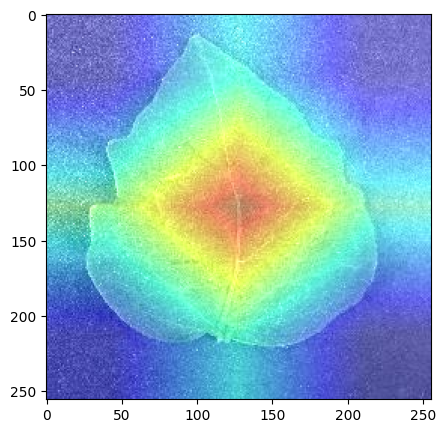

In [22]:
plot_results(model, "/content/plantdisease/PlantVillage/healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG", classes)

1/1 [==============================] - 0s 118ms/step


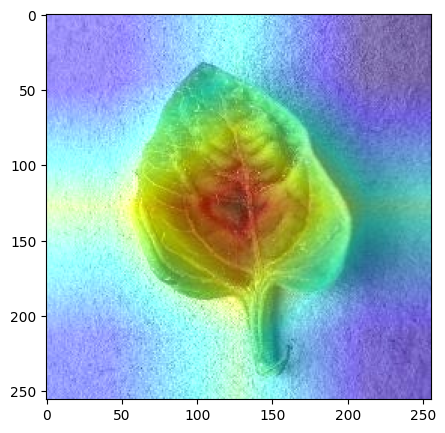

In [23]:
plot_results(model, "/content/plantdisease/PlantVillage/yellow_leaf/00139ae8-d881-4edb-925f-46584b0bd68c___YLCV_NREC 2944.JPG", classes)